**Oreum Industries Internal Project, 2024Q3**

---

# 300_Piecewise_CoxPH1.ipynb

### Survival Regression Demo in `oreum_survival`

Demonstrate Survival Regression Modelling using Bayesian inference and a 
Bayesian workflow, specifically using the `pymc` & `arviz` ecosystem.

We have departed from equivalents to the pre-packaged max-likelihood models, to use the full power 
of the Bayesian framework to create bespoke models with a variety of hierarchical parameters 
(aka mixed random effects), time-dependent ordinal parameters and more. 

In this __30x_Piecewise family__ series of notebooks we demonstrate the theory and 
usage of **Piecewise aka semi-parametric regression** models in the CoxPH family
with different, increasingly sophsiticated, treatments of the baseline hazard function.

**In this Notebook:**

+ We extend our basic understanding with worked examples of semi-parametric models in the CoxPH
  architecture family, using our real-world observational censored dataset.
+ Specifically **Extending CoxPH: Hierarchical Baseline Hazard**

This notebook directly follows (and is dependent
upon the previous execution of) the `10*_*` series of notebooks, in 
particular `102_Exponential_CoxPH0.ipynb` and the `CoxPH0` model, using the 
same simple real-world observational censored dataset.

## Contents

+ [Setup](#Setup)

+ [0. Load Dataset](#0.-Load-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Custom Bayesian Model `CoxPH1`](#2.-Custom-Bayesian-Model-`CoxPH1`)

---

---

# Setup

## Imports

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from oreum_core import curate, eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))


from engine import logger
from model import exponential, piecewise, utils

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip
import seaborn as sns

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('300_Piecewise_CoxPH1', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
RNG = np.random.default_rng(seed=42)
STEP = 14

## Data Connections and Helper Objects

In [4]:
csvio = curate.PandasCSVIO(here(Path('data', 'raw', 'verbatim')).resolve(strict=True))
ppqio = curate.PandasParquetIO(here(Path('data', 'prepared')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# 0. Load Dataset

In [5]:
dfr = csvio.read(fn='mastectomy', index_col='rowid')
eda.display_ht(dfr)

,time,event,metastized
rowid,,,
0,23,True,no
1,47,True,no
2,69,True,no
41,212,False,yes
42,217,False,yes
43,225,False,yes


'Shape: (44, 3), Memsize 0.0 MB'

##### Correct dtypes etc

In [6]:
df = dfr.copy()
df['pid'] = ['p{}'.format(x) for x in range(len(df))]
df = df.reset_index(drop=True).set_index('pid')
df.rename(columns={'time': 'duration', 'event': 'death', 'metastized': 'met'}, inplace=True)
df['death'] = df['death'].astype(bool)
df['met'] = df['met'].apply(lambda x: True if str(x).strip() == 'yes' else False)
eda.describe(df)

,28,3,33,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p28,p3,p33,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,68,70,109,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death,True,False,False,bool,0,NaN,NaN,2,True,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
met,True,False,True,bool,0,NaN,NaN,2,True,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Shape: (44, 4), Memsize 0.0 MB'

---

---

# 1. Model Description

## 1.1 Extending CoxPH: Hierarchical Baseline Hazard

In `102_Exponential_CoxPH0.ipynb` we demonstrated a simple model `CoxPH0` which has an unpooled baseline hazard 
$\lambda_{0}$ and unpooled static covariates $\beta$. 

Also see $\S1$ in that notebook for a detailled description of the core CoxPH model architecture and our Bayesian 
implementation via the "Equivalent Poisson Model"

**Here:** 

We create a more sophisticated model `CoxPH1` which has a **partially-pooled (aka hierarchial aka mixed-random-effects) 
baseline hazard** $\lambda_{0}(t)$ and unpooled static covariates $\beta$
+ The partial pooling constrains $\lambda_{0}(t)$ toward a group mean, encouraging a more robust fit
+ We use a non-centered parameterisation because the data is relatively sparse, thus the FreeRV parmeters will be 
  less well-informed, and we want to allow greater space of sampling. 
+ We will improve this still further in later notebooks
+ Note the priors are very sensitive, especially on the very small dataset that we're using

For more info see 
[Hierarchical Modeling, Betancourt, Nov 2020, Section 3.2](https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html#32_Learning_the_Individual_Parameters), a 
[worked example from Thomas Weicki](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/), and more 
discussion of the practical impacts on the 
[pymc Discourse](https://discourse.pymc.io/t/non-centering-results-in-lower-effective-sample-size/5850)


---

---

# 2. Custom Bayesian Model `CoxPH1`

## 2.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use this transformed dataset `dfx` 
in all subsequent models where possible

NOTE:

+ For this example Notebook we will _not_ partition into train & holdout sets
  (see `README.md ## 5. Data Standards` for terminology)
+ Instead we will simply fit the entire dataset and evaluate in-sample using
  Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ This means we still follow our standard process for preparation, 
  transformation, standardization, but abbreviate to `dfa` only


In-house preferred process (transformation, standardization) to create `dfx` for model usage 

In [7]:
dfx_creator = utils.ProjectDFXCreator()
dfx = dfx_creator.get_dfx(df)
eda.describe(dfx)

,3,30,36,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p3,p30,p36,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,70,76,118,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death_t_true,0,0,1,int64,0,0.0,18.0,NaN,NaN,NaN,26.0,0.59,0.5,0.0,0.0,1.0,1.0,1.0
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,44.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
met_t_true,0,1,1,int64,0,0.0,12.0,NaN,NaN,NaN,32.0,0.73,0.45,0.0,0.0,1.0,1.0,1.0


'Shape: (44, 5), Memsize 0.0 MB'

## 2.1 Build Model Object

`CoxPH1` model imported from `src.models.piecewise.py` where it is fully defined

In [8]:
mdl_cox1 = piecewise.CoxPH1(obs=dfx, fts_en=dfx_creator.fts_en, 
                factor_map=dfx_creator.factor_map, bin_width=STEP, obs_nm='dfx')
mdl_cox1.build()
utils.display_rvs(mdl_cox1)
mdl_cox1.debug()

'RVs for coxph1, v1.1.0, dfx'

lambda_j_mu ~ Normal(-5, 1)

lambda_j_mu_offset ~ Normal(0, 1)

lambda_j_sigma ~ InverseGamma(101, 100)

beta ~ Normal(0, 1)

lambda_j ~ Deterministic(f(lambda_j_mu_offset, lambda_j_mu, lambda_j_sigma))

shat_ij ~ Deterministic(f(beta, lambda_j_mu_offset, lambda_j_mu, lambda_j_sigma))

point={'lambda_j_mu': array(-5.), 'lambda_j_mu_offset': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'lambda_j_sigma_log__': array(0.), 'beta': array([0.])}

No problems found
point={'lambda_j_mu': array(-5.), 'lambda_j_mu_offset': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'lambda_j_sigma_log__': array(0.), 'beta': array([0.])}

No problems found


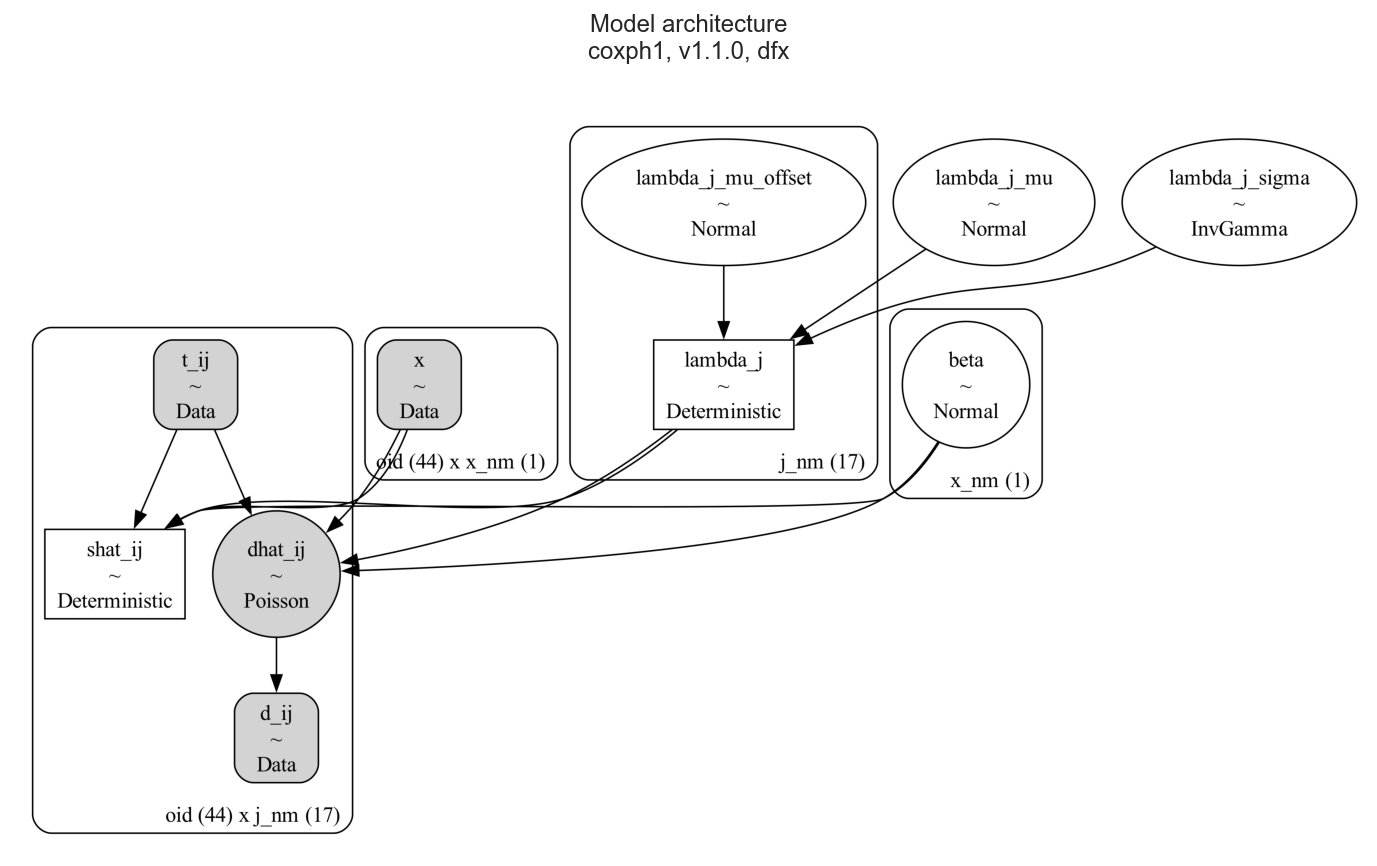

In [9]:
fqn = mdlio.write_graph(mdl_cox1)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdl_cox1.mdl_id}', figsize=(12, 6))

## 2.2 Sample Prior Predictive, View Diagnostics

In [10]:
mdl_cox1.sample_prior_predictive(var_names=mdl_cox1.rvs_lam + mdl_cox1.rvs_b + mdl_cox1.rvs_det + mdl_cox1.rvs_ppc, replace=True)

### 2.2.1 Evaluate PPC vs In-Sample Data

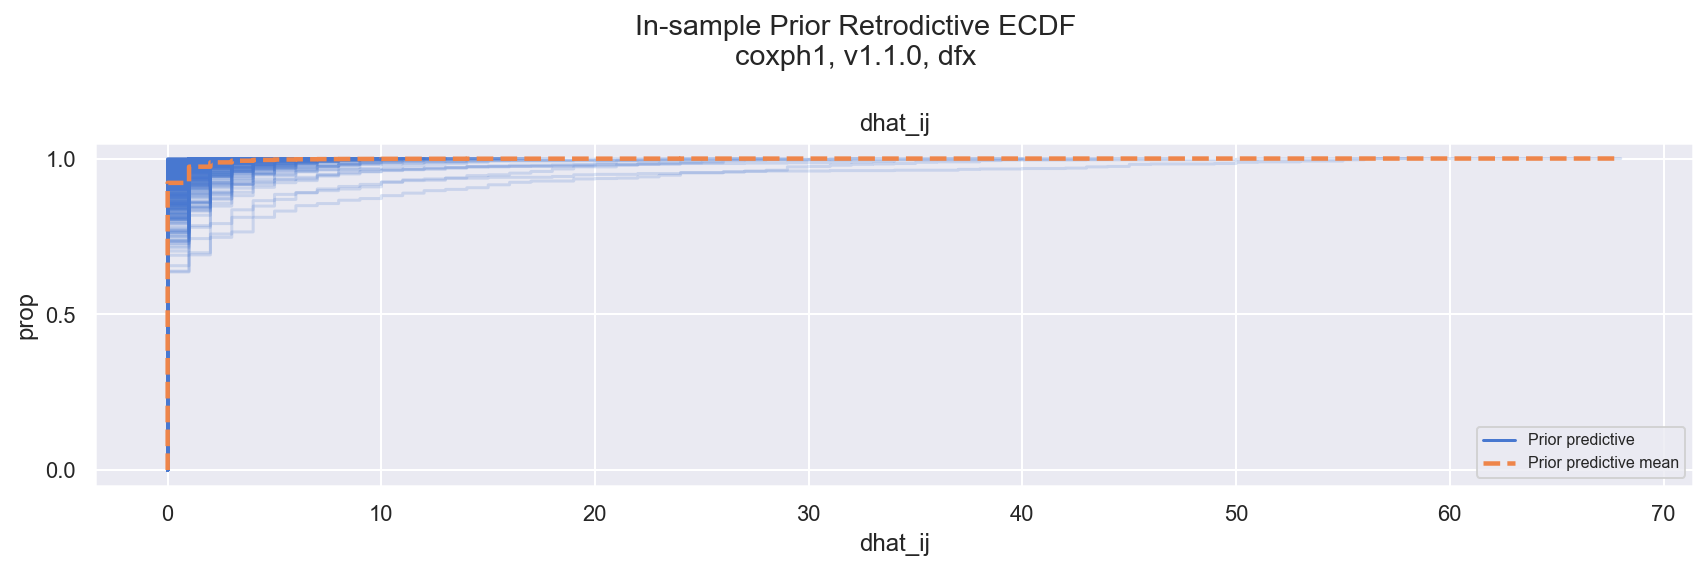

In [11]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdl_cox1, group=GRP, var_names=['dhat_ij'], insamp=True)

**Observe:**

+ Terrible fit as expected, but the range is technically valid considering its Poisson

### 2.2.2 Evaluate priors and hyperpriors

#### Hyperpriors on hazard function

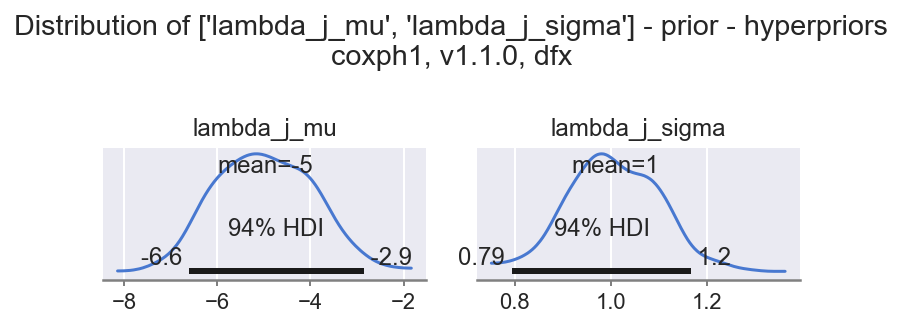

In [12]:
f = mt.facetplot_krushke(mdl=mdl_cox1, group=GRP, txtadd='hyperpriors', rvs=['lambda_j_mu', 'lambda_j_sigma'], m=2)

**Observe**

+ We've set `lambda_j_mu` low to achieve `E(lj) ~ exp(-5) = 0.007`
+ We've set `lambda_j_sigma` to `1` but may need to tighten this up

#### Baseline hazard function $\lambda_{0}$

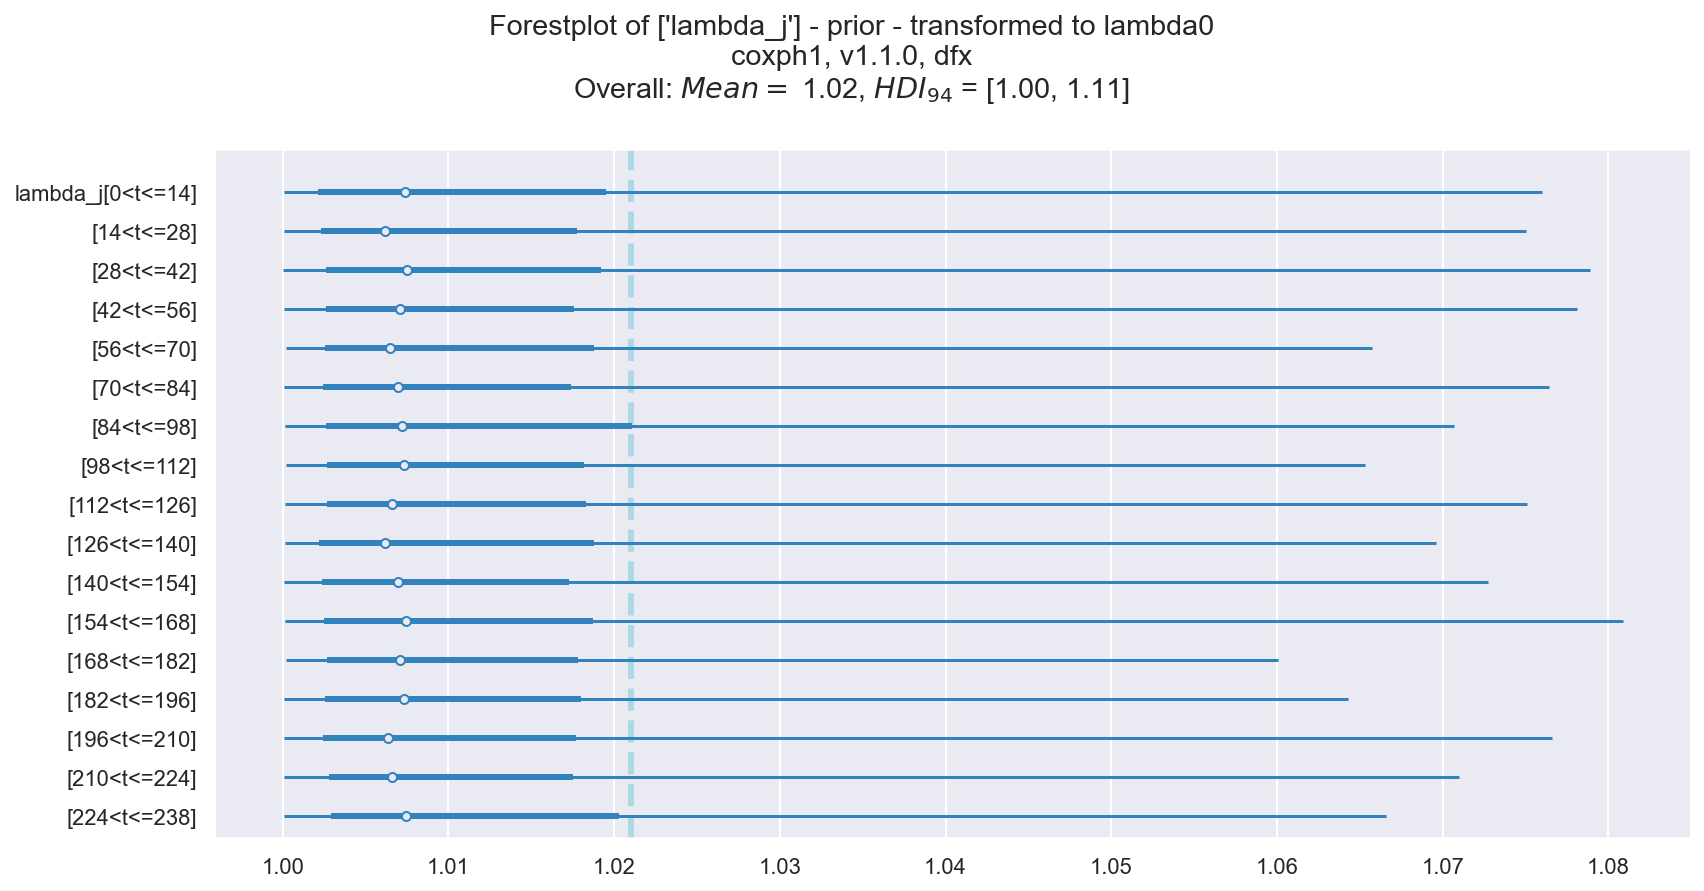

In [13]:
f = mt.forestplot_single(mdl=mdl_cox1, var_names=['lambda_j'], group=GRP,
            transform=np.exp, txtadd='transformed to lambda0')

**Observe**

+ Priors sitting away from 1, so some effect already - may need to adjust this
+ `HDI94`s nice and wide but very skewed, leading to a high mean

#### Priors on beta

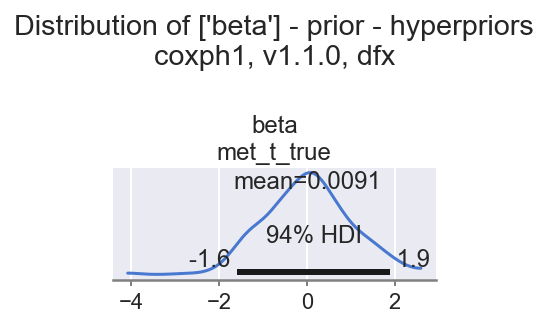

In [14]:
f = mt.facetplot_krushke(mdl=mdl_cox1, group=GRP, txtadd='hyperpriors', rvs=mdl_cox1.rvs_b)

**Observe:**

+ Nice wide HDI94 span centered on 0 (no effect)

## 2.3 Sample Posterior, View Diagnostics

In [15]:
mdl_cox1.sample(progressbar=True)
mdl_cox1.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdl_cox1.rvs_ppc)
mdlio.write_idata(mdl=mdl_cox1)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_survival/data/models/idata_coxph1_v110_dfx.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_j_mu,-5.860,0.418,-6.658,-5.096,0.012,0.009,1184.0,1469.0,1.0
lambda_j_mu_offset[0<t<=14],0.196,0.522,-0.855,1.085,0.014,0.010,1442.0,1054.0,1.0
lambda_j_mu_offset[14<t<=28],0.496,0.527,-0.503,1.485,0.012,0.009,1824.0,1432.0,1.0
lambda_j_mu_offset[28<t<=42],0.381,0.561,-0.669,1.424,0.014,0.010,1637.0,1423.0,1.0
lambda_j_mu_offset[42<t<=56],0.246,0.569,-0.861,1.293,0.014,0.012,1643.0,1295.0,1.0
lambda_j_mu_offset[56<t<=70],0.587,0.569,-0.568,1.550,0.013,0.009,2037.0,1281.0,1.0
lambda_j_mu_offset[70<t<=84],-0.265,0.700,-1.608,0.997,0.016,0.015,2062.0,1288.0,1.0
lambda_j_mu_offset[84<t<=98],-0.796,0.812,-2.380,0.687,0.018,0.015,2073.0,1424.0,1.0
lambda_j_mu_offset[98<t<=112],-0.739,0.805,-2.168,0.797,0.017,0.014,2259.0,1401.0,1.0
lambda_j_mu_offset[112<t<=126],0.430,0.709,-0.891,1.777,0.014,0.014,2442.0,1510.0,1.0


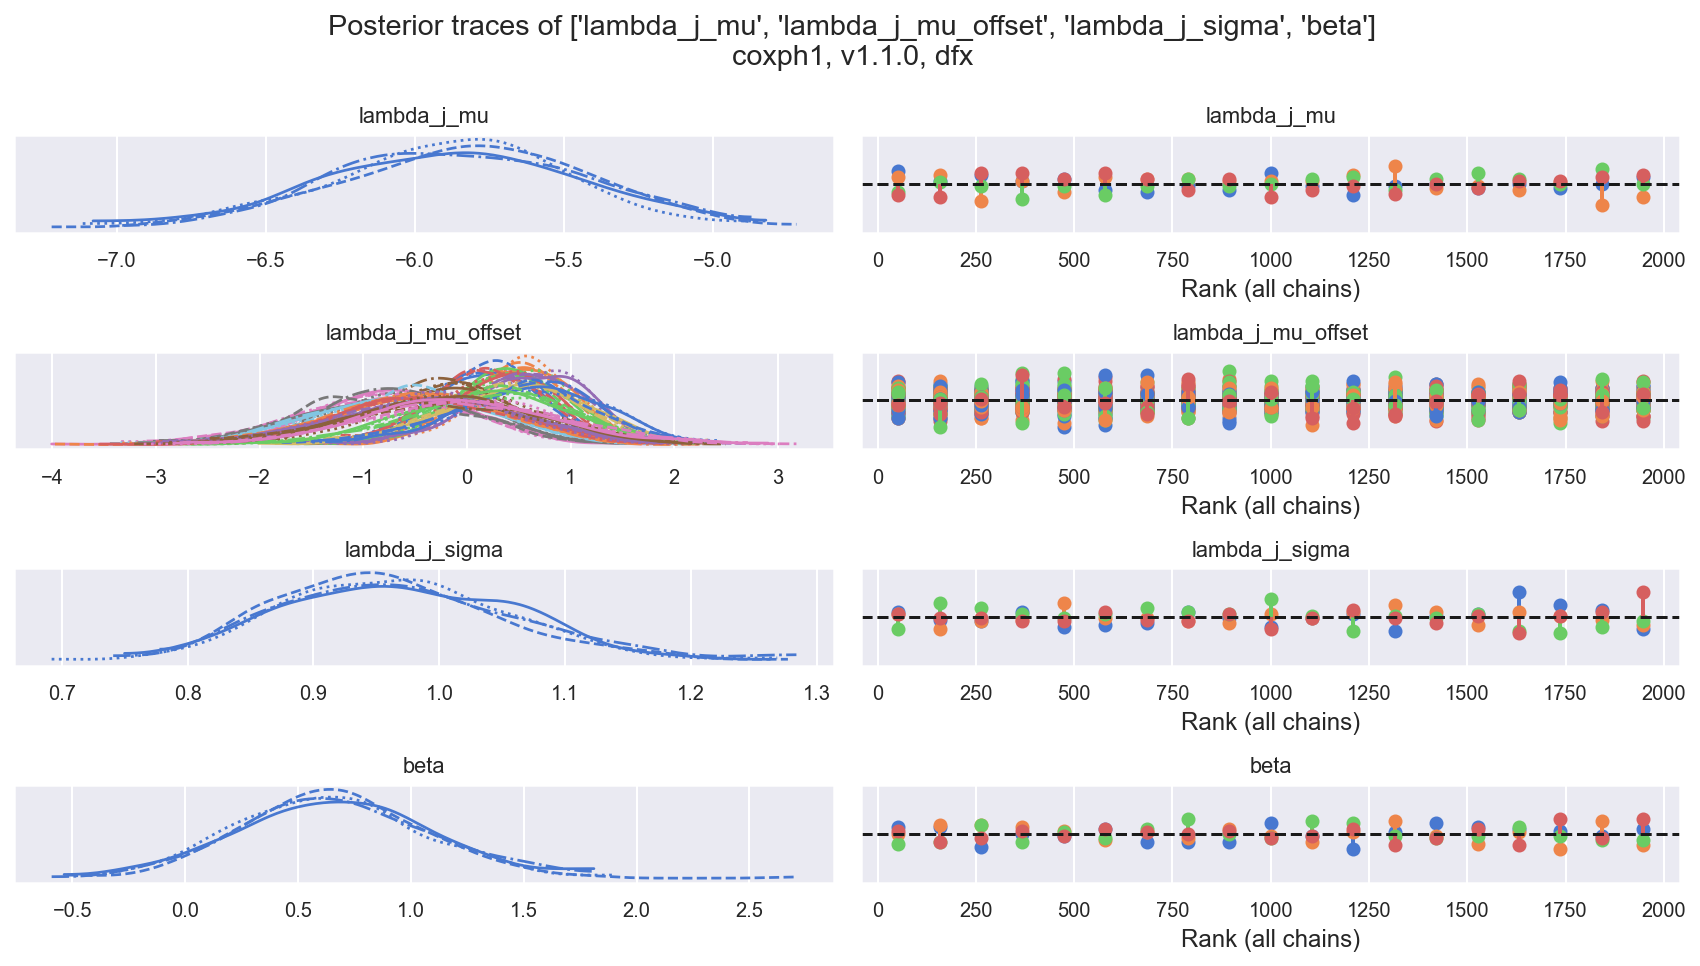

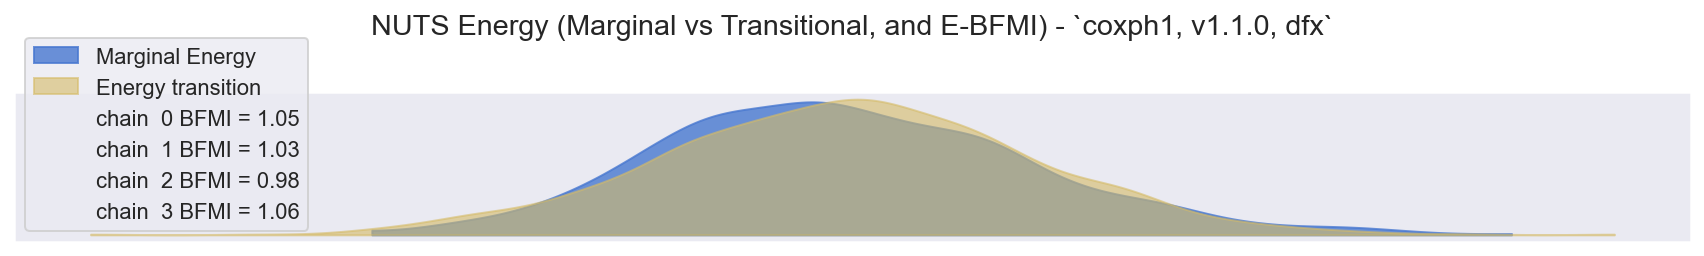

In [16]:
f = mt.plot_trace(mdl=mdl_cox1, rvs=mdl_cox1.rvs_lam + mdl_cox1.rvs_b)
f = mt.plot_energy(mdl=mdl_cox1)
smry = mt.get_summary(mdl=mdl_cox1, rvs=mdl_cox1.rvs_lam + mdl_cox1.rvs_b)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 2.4 Evaluate Posterior PPC (In-Sample) via ECDF

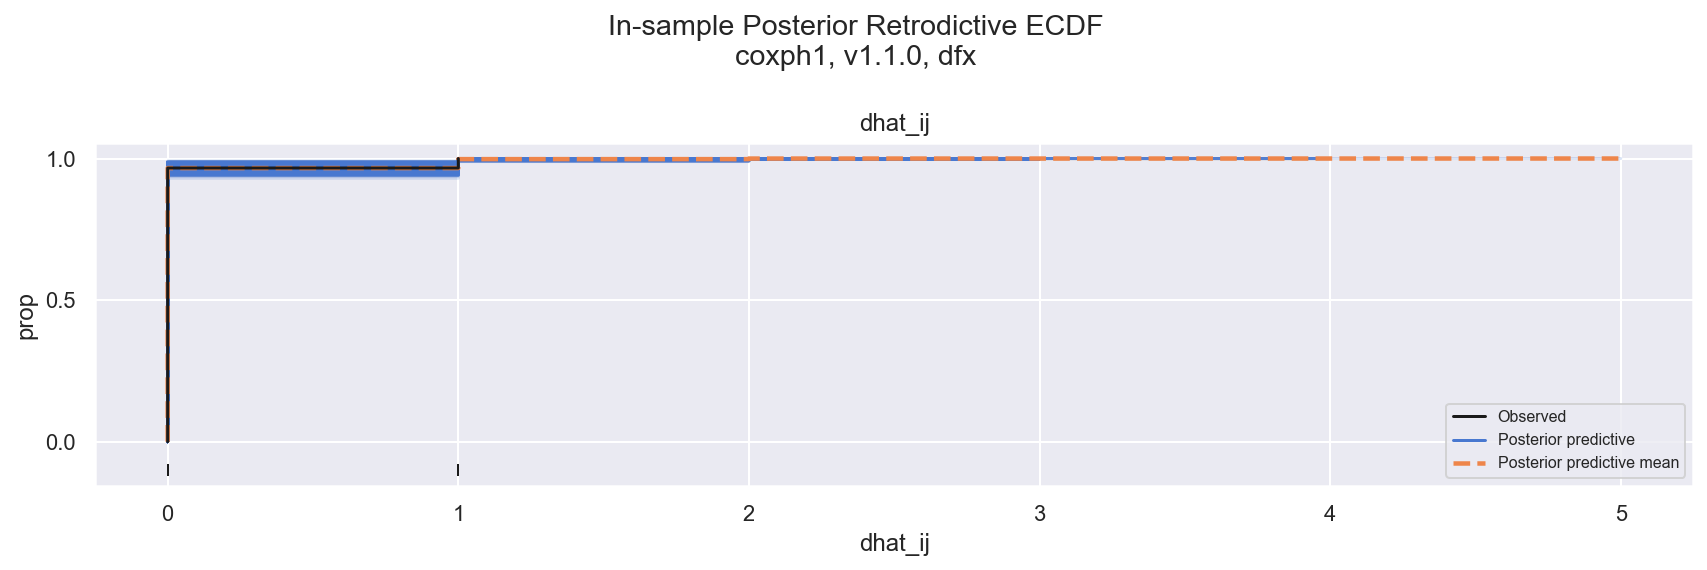

In [17]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdl_cox1, group=GRP, var_names=['dhat_ij'], insamp=True)

**Observe:**

+ This is a pretty nice fit, tight around the real observations $d \in \{0, 1\}$
+ There's still (inevitably) non-zero PPC mass at $d \gt 1$, which is not valid given the problem-space definition (can't die more than $1x$ in an interval!)

## 2.5 Evaluate via LOO-PIT plots (In-Sample)

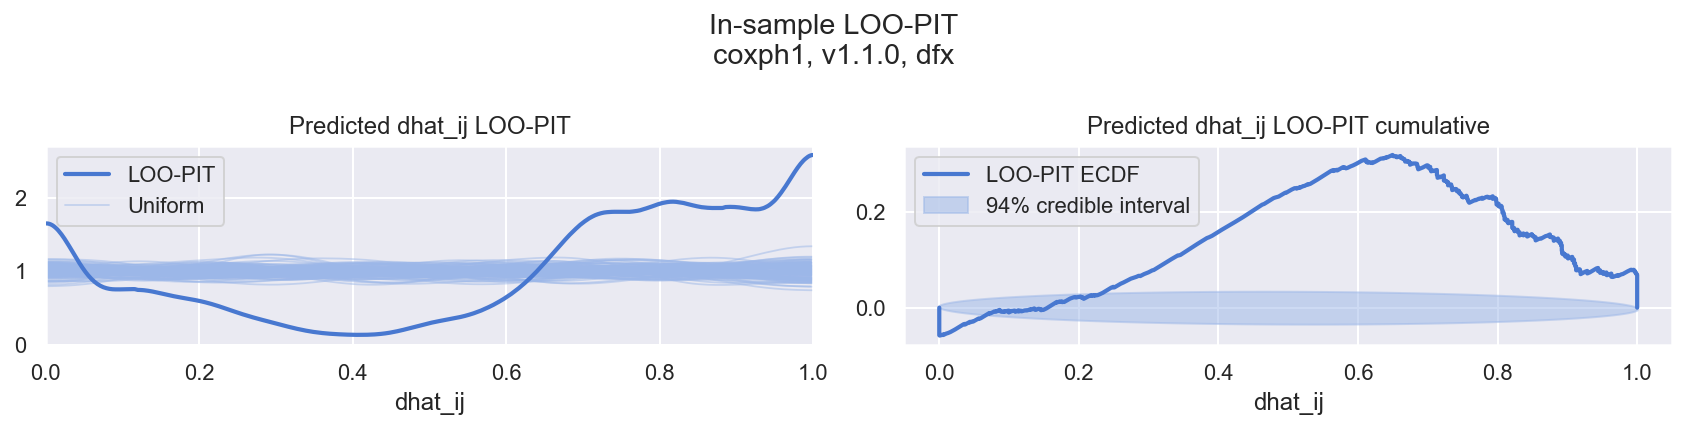

In [18]:
f = mt.plot_loo_pit(mdl_cox1, data_pairs={'dhat_ij': 'dhat_ij'})

**Observe**

+ This LOO-PIT report indicates a poor fit, with underdispersion and bias
+ This isn't a surprise given that the Poisson likelihood has mass at d > 1

## 2.6 Compare Log-Likelihood vs other models

### 2.6.1 Reinstantiate earlier models for comparison

In [19]:
mdl_cox0 = exponential.CoxPH0(obs=dfx, fts_en=dfx_creator.fts_en, 
                factor_map=dfx_creator.factor_map, bin_width=STEP, obs_nm='dfx')
mdl_cox0.build()
mdl_cox0_idata = mdlio.read_idata(mdl=mdl_cox0)
mdl_cox0.update_idata(idata=mdl_cox0_idata)

### 2.6.2 Compare

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mdl_cox0\ncoxph0_v120_dfx,0,-111.209552,6.318815,0.000000,1.0,16.524149,0.000000,True,log
mdl_cox1\ncoxph1_v110_dfx,1,-112.107016,8.231668,0.897464,0.0,16.990134,0.711247,True,log


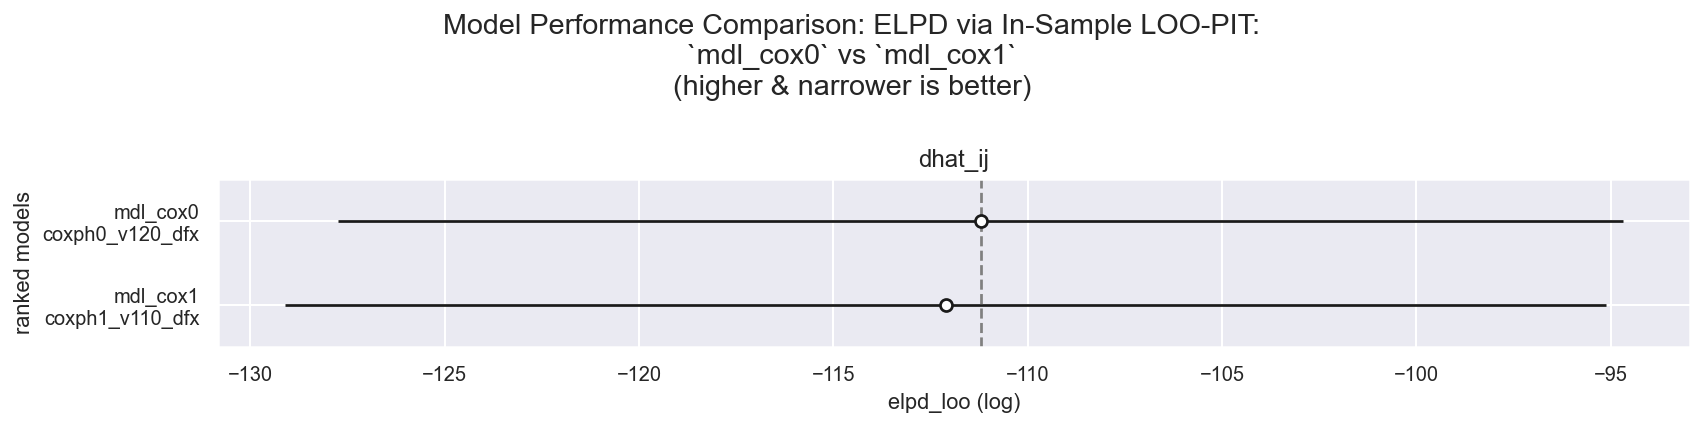

In [20]:
mdl_dict = {'mdl_cox0': mdl_cox0, 'mdl_cox1': mdl_cox1}
f, dcomp = mt.plot_compare(mdl_dict, yhats=['dhat_ij'])
_ = [display(d) for d in dcomp.values()]

**Observe:**

+ Very interesting! the original unpooled `CoxPH0` (with fewer degrees of freedom) seems to score better under ELPD, 
  although only slightly, and with substantial overlap

In [21]:
del mdl_cox0

## 2.7 Evaluate Posterior Parameters

### 2.7.1 Hyperpriors on hazard function

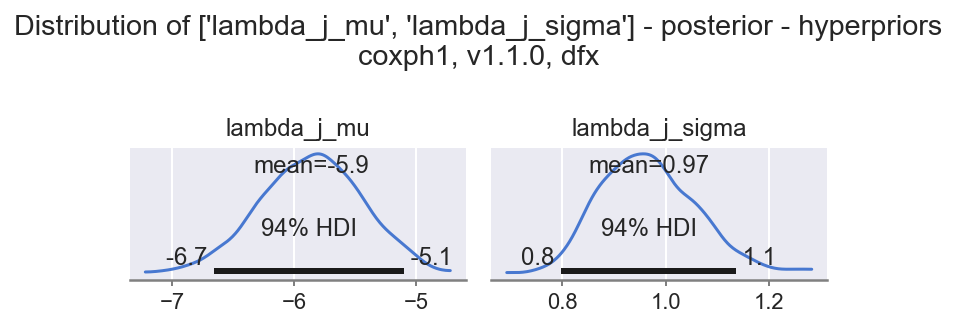

In [22]:
f = mt.facetplot_krushke(mdl=mdl_cox1, group=GRP, txtadd='hyperpriors', rvs=['lambda_j_mu', 'lambda_j_sigma'], m=2)

**Observe:**

+ `lambda_j_mu`: $\mathbb{E} \sim -5.9$, $\text{HDI}_{94}$ narrower than prior, baseline hazard `E(lj) ~ exp(-6) ~ 0.0025`
+ `lambda_j_sigma`: $\mathbb{E} \sim 0.97$, $\text{HDI}_{94}$ narrower than prior

### 2.7.2 Baseline hazard function $\lambda_{0}$

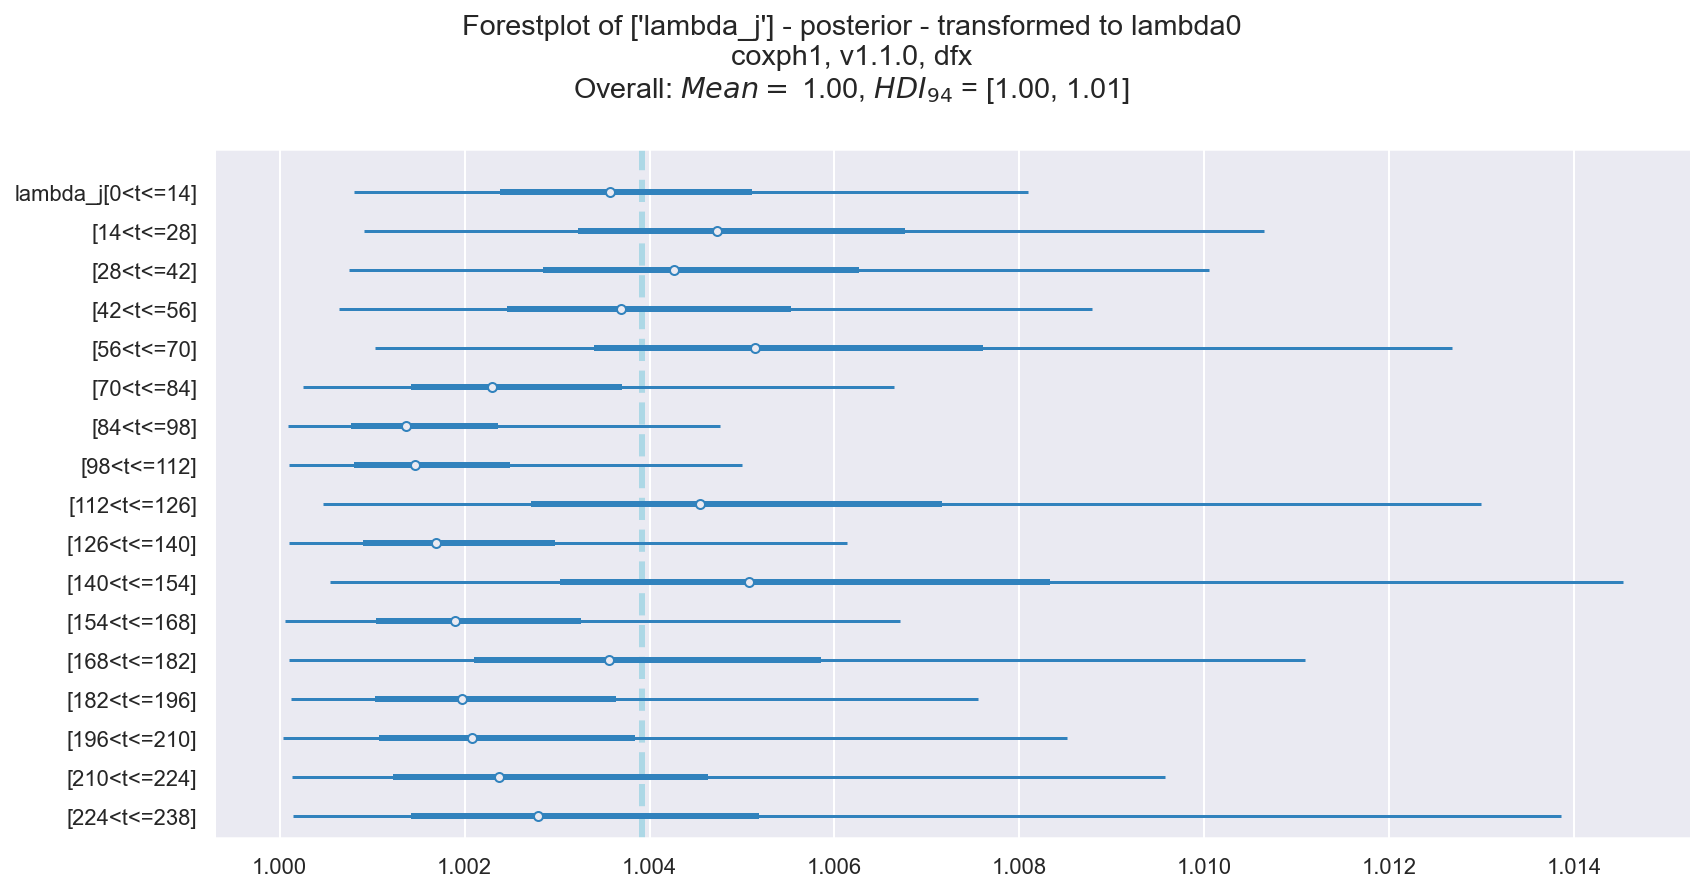

In [23]:
f = mt.forestplot_single(mdl=mdl_cox1, var_names=['lambda_j'], group=GRP, combined=True,
            transform=np.exp, txtadd='transformed to lambda0')

**Observe:**

+ Posteriors look reasonable and we see the effect of allowing $\lambda_{0}$ to vary across time interval
+ Compare to `mdl_cox0` (in `102_Exponential_CoxPH0.ipynb` $\S3.7$): in `mdl_cox1` we see a shrinkage of mass toward the group
  mean (as expected) - which should yield better generalisation, but the distributions are much wider, suggesting 
  variance in the data is not sufficiently mapped to model parameters

### 2.7.3 Priors `beta`

Note we transform `beta` to `exp(beta)`, which for this simple dataset gets us the proportional hazard of `met=True`

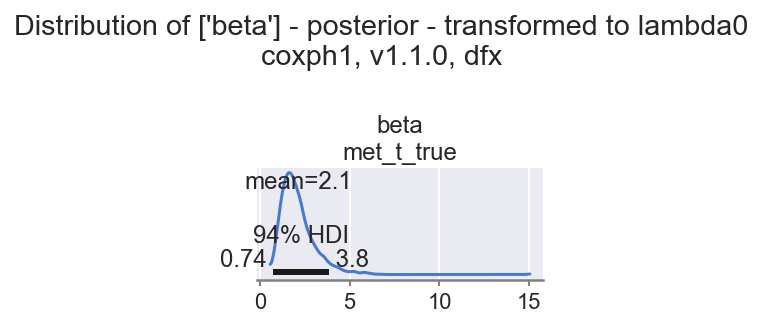

In [24]:
f = mt.facetplot_krushke(mdl=mdl_cox1, group=GRP, rvs=mdl_cox1.rvs_b, transform=np.exp, txtadd='transformed to lambda0')

**Observe**

+ `beta: met_t_true`
+ `beta: met_t_true`: $\mathbb{E} \sim 2.3$, $0 \notin \text{HDI}_{94}$! Substantially moves $\lambda$ to earlier mortality
+ This is a similar but wider value than `CoxPH0` found, and makes sense if we consider that the hierarchical prior on
  $\lambda_{0}(t)$ is now more tightly defined, so `beta` has to widen to compensate, in the case that we haven't 
  removed variance with additional regression parameters

## 2.8 Forecast Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

Because this model is semi-parametric, we can **forecast** Survival $\hat{S}(j)$ for observations in an **out-of-sample dataset**

However, unlike the fully parametric models:
+ We don't get Expected Time-to-Event "for free" out of the model, because it doesnt have the concept of $\hat{\mathbb{E}}_{t} \sim S^{-1}(u)$
+ Instead, we have to interpolate $\hat{\mathbb{E}}_{t} \sim \int_{0}^{t_{max}} dt \ S(t)$

> See the full detailled discussion in `100_Exponential_Univariate.ipynb` $\S3.8$

### 2.8.1 Create synthetic dataset, calc PPC and extract PPC components

In [25]:
dfs = utils.get_synthetic_df_oos(df, is_coxph=True)
dfsx = dfx_creator.get_dfx(dfs, in_sample=False)

mdl_cox1.replace_obs(obsd={'obs': dfsx}, obs_nm='dfsx')
mdl_cox1.build()
f_idata = mdl_cox1.sample_posterior_predictive(store_ppc=False, ppc_insample=True, var_names=mdl_cox1.rvs_ppc)
dfhat = utils.get_ppc_components_as_dfm(f_idata, getx=True, is_coxph=True, j_nm=mdl_cox1.coords['j_nm'])
dfp = pd.merge(dfhat, dfs.reset_index(), how='left', left_on='oid', right_on='pid')
eda.display_ht(dfp)

Output()

,oid,j_nm,chain,draw,shat_ij,dhat_ij,oid_sub,t_ij,t,tau_min,tau_max,met_t_true,pid,met,death,duration
0,z000,0<t<=14,0,0,0.88,1,z000,14,14,0,14,0,z000,False,False,225
1,z000,0<t<=14,0,1,0.91,0,z000,14,14,0,14,0,z000,False,False,225
2,z000,0<t<=14,0,2,0.98,0,z000,14,14,0,14,0,z000,False,False,225
67997,z001,224<t<=238,3,497,0.14,0,z001,1,225,224,238,1,z001,True,False,225
67998,z001,224<t<=238,3,498,0.20,0,z001,1,225,224,238,1,z001,True,False,225
67999,z001,224<t<=238,3,499,0.22,0,z001,1,225,224,238,1,z001,True,False,225


'Shape: (68000, 16), Memsize 8.7 MB'

### 2.8.2 Plot estimated Survival $\hat{S}(j)$ at intervals $j$ and $\hat{S}(t)$ as interpolated smooth $t$

NOTE:

+ The CoxPH model operates on ordinal intervals $j$, so we must distinguish between predictions $\hat{S}(j)$ vs $\hat{S}(t)$
+ We plot $\hat{S}(j)$ as ordinal points and make no attempt to interpolate time
+ We plot $\hat{S}(t)$ as lines with linearly interpolated time

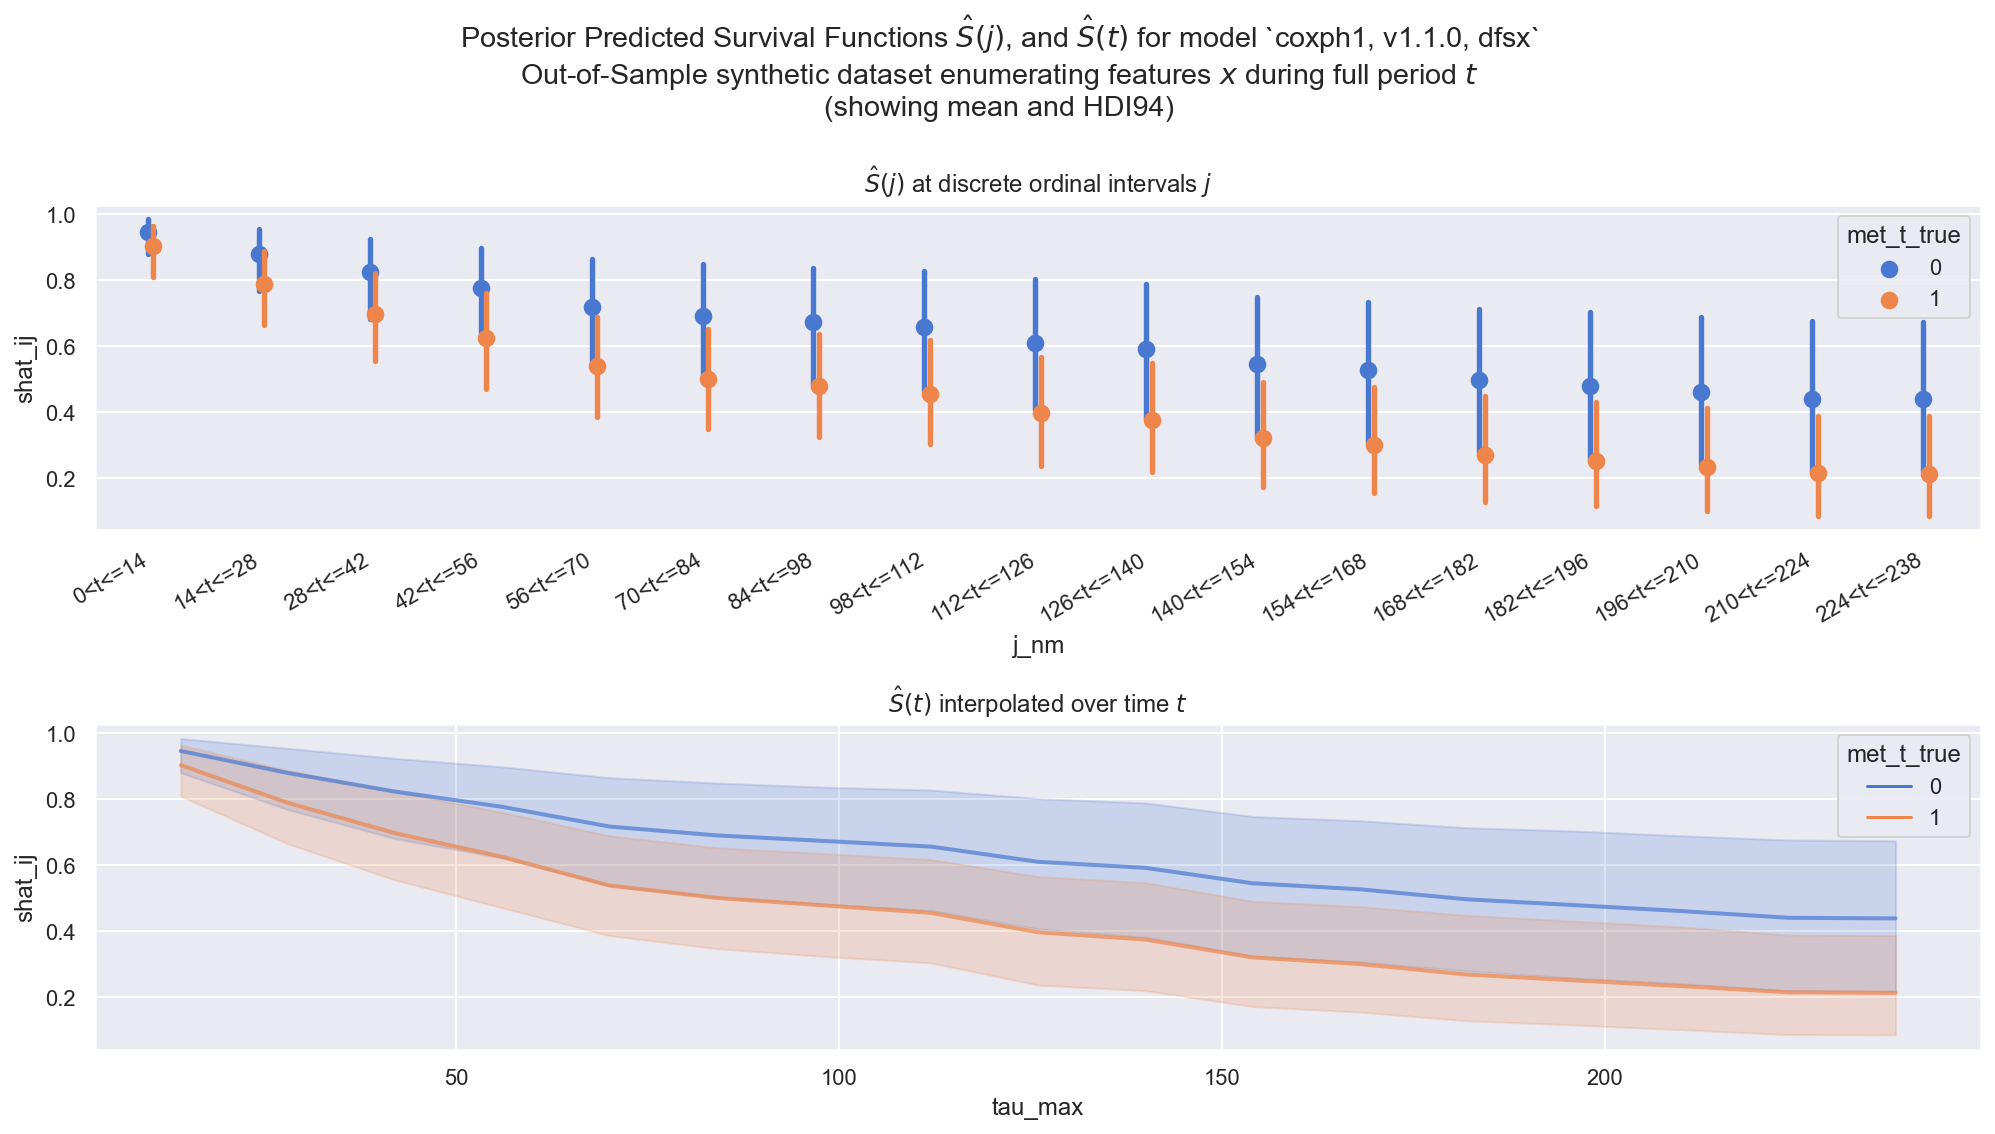

In [26]:
f, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
ax0 = sns.pointplot(x='j_nm', y='shat_ij', hue='met_t_true', data=dfp, join=False, dodge=True, ax=axs[0], 
                    estimator='mean', errorbar=('pi', 94))
_ = ax0.set_xticklabels(ax0.get_xticklabels(), rotation=30, ha='right')
_ = ax0.set_title('$\hat{{S}}(j)$ at discrete ordinal intervals $j$')
ax1 = sns.lineplot(x='tau_max', y='shat_ij', hue='met_t_true', data=dfp, style='met_t_true', ms=10, dashes=False, alpha=0.7, 
                legend=True, lw=2, ax=axs[1], estimator='mean', errorbar=('pi', 94), err_style='band')
_ = ax1.set_title('$\hat{{S}}(t)$ interpolated over time $t$')
_ = f.suptitle(f'Posterior Predicted Survival Functions $\hat{{S}}(j)$, and $\hat{{S}}(t)$ for model `{mdl_cox1.mdl_id}`'
    + '\nOut-of-Sample synthetic dataset enumerating features $x$ during full period $t$'
    + '\n(showing mean and HDI94)')
_ = f.tight_layout()
fqn = figio.write(f, fn=f'300_{mdl_cox1.mdl_id}_forecast_shat')

**Observe:**

+ Even though we saw a reasonably distinguishing value for $\hat{\lambda(t | met=True)}$,
  the combination with $\hat{\lambda_{0}}(t)$ leads to posterior predictions of $\hat{S}(t)$ that still have substantial
  overlap between groups `met`
+ As we saw above, $\hat{\lambda_{0}}(t)$ has such span that it's taking explanatory power from $\beta$. In forthcoming
  models below we will require $\hat{\lambda_{0}}(t)$ to be more tightly defined via a tighter hierarchical structure

### 2.8.3 Expected time-to-event $\hat{\mathbb{E}}_{t}$

We integrate the curve $\hat{S}(t)$ assuming linearly interpolated time

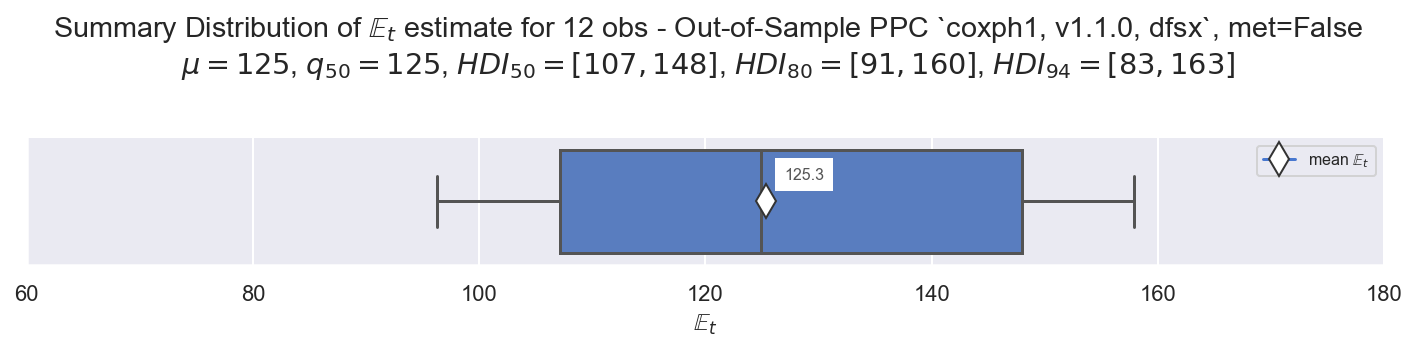

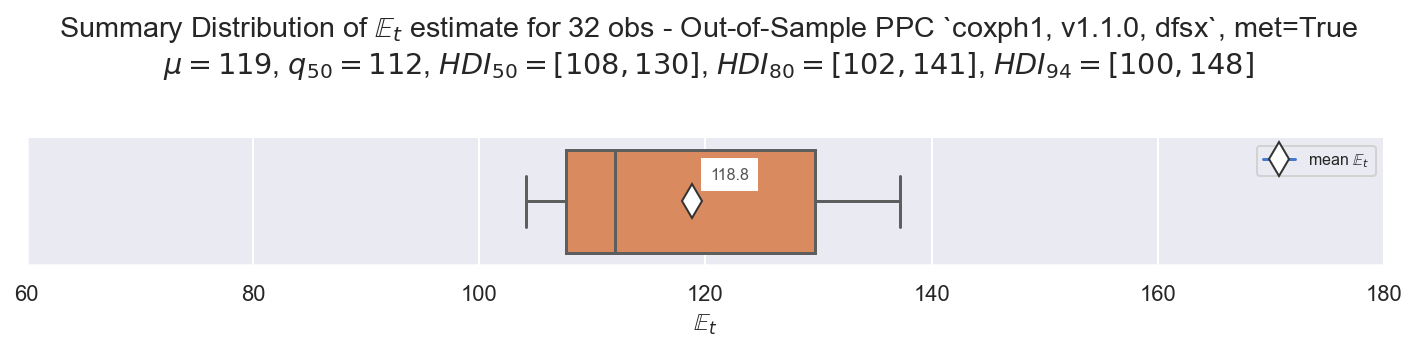

In [27]:
df_et = dfp.groupby(['oid_sub', 'chain', 'draw', 'met_t_true'])\
            .apply(lambda g: np.trapz(y=g['shat_ij'], x=g['tau_max']), include_groups=False)\
            .to_frame('$\mathbb{E}_{t}$')
            
f = eda.plot_estimate(df=df_et.loc[:, :, 0], nobs=len(dfx) - dfx['met_t_true'].sum(), yhat='$\mathbb{E}_{t}$',
    txtadd=f'Out-of-Sample PPC `{mdl_cox1.mdl_id}`, met=False',force_xlim=(60, 180))
fqn = figio.write(f, fn=f'300_{mdl_cox1.mdl_id}_forecast_et_met_false')

f = eda.plot_estimate(df=df_et.loc[:, :, 1],nobs=dfx['met_t_true'].sum(), yhat='$\mathbb{E}_{t}$',
    txtadd=f'Out-of-Sample PPC `{mdl_cox1.mdl_id}`, met=True', color='C1', force_xlim=(60, 180))
fqn = figio.write(f, fn=f'300_{mdl_cox1.mdl_id}_forecast_et_met_true')

**Observe:**

+ Now here's the distribution of forecasted expected survival times $\mathbb{E}_{t}$ for our **synthetic out-of-sample dataset**
  + For `met = False`: $\mathbb{E}_{t} \sim 125 \in [83, 163]_{HDI94}$ days
  + For `met = True`: $\mathbb{E}_{t} \sim 119 \in [100, 148]_{HDI94}$ days
+ These empirical predicted distributions have substantial degree of overlap
+ These results continue to broadly agree with our Exponential and CoxPH models to date (and the directional effect of met = True)

---

---

# Notes

In [28]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-18 18:01:51

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

pymc    : 5.16.2
pytensor: 2.25.5

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pyprojroot: 0.3.0
matplotlib: 3.9.2
seaborn   : 0.12.2
pandas    : 2.2.3
numpy     : 1.26.4
oreum_core: 0.9.7
sys       : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]



---
**Oreum OÜ &copy; 2024**